<a href="https://colab.research.google.com/github/THREELabs/Deeplearning/blob/main/Deep_Learning_Stock_Predition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
df = pd.read_csv("AMC1.csv", index_col = 0)

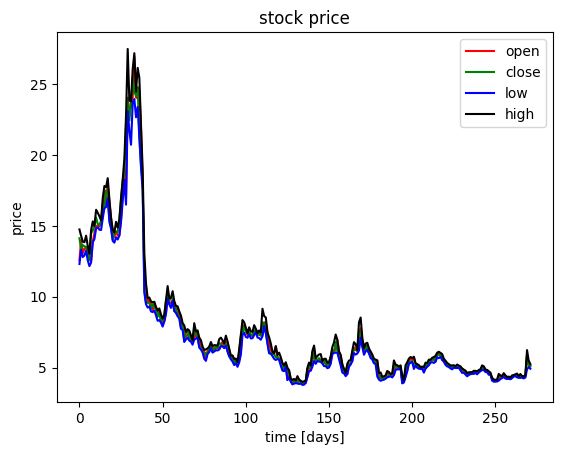

In [52]:
import matplotlib.pyplot as plt
#df = df[df.symbol == 'AMC'] --- I disabled this because  didn't have this column in csv file
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')

In [53]:
import sklearn.preprocessing
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
data = df[['open','close','low','high']].values

In [54]:
import numpy as np
seq_len=20
sequences=[]
for index in range(len(data) - seq_len):
  sequences.append(data[index: index + seq_len])
sequences= np.array(sequences)

In [55]:
valid_set_size_percentage = 10
test_set_size_percentage = 10

valid_set_size = int(np.round(valid_set_size_percentage/100*sequences.shape[0]))
test_set_size  = int(np.round(test_set_size_percentage/100*sequences.shape[0]))
train_set_size = sequences.shape[0] - (valid_set_size + test_set_size)

x_train = sequences[:train_set_size,:-1,:]
y_train = sequences[:train_set_size,-1,:]

x_valid = sequences[train_set_size:train_set_size+valid_set_size,:-1,:]
y_valid = sequences[train_set_size:train_set_size+valid_set_size,-1,:]

x_test = sequences[train_set_size+valid_set_size:,:-1,:]
y_test = sequences[train_set_size+valid_set_size:,-1,:]

In [56]:
import torch
from torch.utils.data import TensorDataset, DataLoader

x_train = torch.tensor(x_train).float()
y_train = torch.tensor(y_train).float()

x_valid = torch.tensor(x_valid).float()
y_valid = torch.tensor(y_valid).float()

train_dataset = TensorDataset(x_train,y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = TensorDataset(x_valid,y_valid)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

In [57]:
from torch import nn
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.lstm  = nn.LSTM(4,64,batch_first=True)
        self.fc    = nn.Linear(64,4)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.fc(hidden)
        return x

model = NeuralNetwork()

#push to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [58]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
mse = nn.MSELoss()

In [59]:
def train(dataloader):
    epoch_loss = 0
    model.train()

    for batch in dataloader:
        optimizer.zero_grad()
        x,y= batch
        pred = model(x)
        loss = mse(pred[0],y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss

In [60]:
def evaluate(dataloader):
    epoch_loss = 0
    model.eval()

    with torch.no_grad():
      for batch in dataloader:
          x,y= batch
          pred = model(x)
          loss = mse(pred[0],y)
          epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

In [61]:
n_epochs = 50
best_valid_loss = float('inf')

for epoch in range(n_epochs):

    train_loss = train(train_dataloader)
    valid_loss = evaluate(valid_dataloader)

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model, 'saved_weights.pt')

    print("Epoch ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.5f}')
    print(f'\tVal Loss: {valid_loss:.5f}\n')

Epoch  1
	Train Loss: 0.51151
	Val Loss: 0.00146

Epoch  2
	Train Loss: 0.34900
	Val Loss: 0.00243

Epoch  3
	Train Loss: 0.18152
	Val Loss: 0.02293

Epoch  4
	Train Loss: 0.15299
	Val Loss: 0.01127

Epoch  5
	Train Loss: 0.10840
	Val Loss: 0.00430

Epoch  6
	Train Loss: 0.09065
	Val Loss: 0.00326

Epoch  7
	Train Loss: 0.06700
	Val Loss: 0.00126

Epoch  8
	Train Loss: 0.06731
	Val Loss: 0.00058

Epoch  9
	Train Loss: 0.05745
	Val Loss: 0.00100

Epoch  10
	Train Loss: 0.05207
	Val Loss: 0.00037

Epoch  11
	Train Loss: 0.05959
	Val Loss: 0.00059

Epoch  12
	Train Loss: 0.04971
	Val Loss: 0.00136

Epoch  13
	Train Loss: 0.04655
	Val Loss: 0.00028

Epoch  14
	Train Loss: 0.04448
	Val Loss: 0.00033

Epoch  15
	Train Loss: 0.03459
	Val Loss: 0.00061

Epoch  16
	Train Loss: 0.04165
	Val Loss: 0.00013

Epoch  17
	Train Loss: 0.03789
	Val Loss: 0.00025

Epoch  18
	Train Loss: 0.02898
	Val Loss: 0.00027

Epoch  19
	Train Loss: 0.02647
	Val Loss: 0.00010

Epoch  20
	Train Loss: 0.02490
	Val Loss

In [62]:
model=torch.load('saved_weights.pt')

In [63]:
x_test = torch.tensor(x_test).clone().detach().requires_grad_(True).float()

with torch.no_grad():
    y_test_pred = model(x_test)

y_test_pred = y_test_pred.numpy()[0]

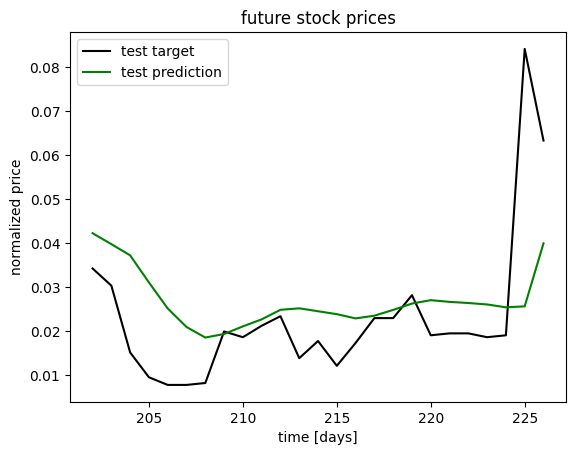

In [65]:
idx=0
plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,idx], color='black', label='test target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,idx], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')